# Detector de mascara sanitaria I (entrenamiento)

Vamos a preparar un detector de mascara con TensorFlow y OpenCV. Primero necesitamos entrenar el modelo con imagenes de caras con y sin mascara.

In [1]:
# librerias
import warnings
warnings.simplefilter('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as report

from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os

In [2]:
# constantes, tasa de aprendizaje, epocas de entrenamiento y tamaño de la muestra

TASA_APRENDIZAJE=1e-4
EPOCAS=20
BATCH_SIZE=32

In [3]:
# lee la lista de imagenes del dataset

print('Cargando imagenes...')

imagenes=list(paths.list_images('dataset'))

print('\nCargadas.')

Cargando imagenes...

Cargadas.


In [4]:
data=[]
etiquetas=[]

for e in imagenes:
    # extrae la etiqueta del nombre del archivo
    etiqueta=e.split(os.path.sep)[-2]

    # carga la imagen (224x224) y procesala
    imagen=load_img(e, target_size=(224, 224))
    imagen=img_to_array(imagen)
    imagen=preprocess_input(imagen)

    # añade a la lista
    data.append(imagen)
    etiquetas.append(etiqueta)

In [5]:
# se convierten datos y etiquetas a arrays de numpy

data=np.array(data, dtype='float32')
etiquetas=np.array(etiquetas)

In [6]:
#  one-hot encoding para etiquetas

_bin=LabelBinarizer()

etiquetas=_bin.fit_transform(etiquetas)
etiquetas=to_categorical(etiquetas)

In [7]:
# train-test split

X_train, X_test, y_train, y_test=tts(data, etiquetas, test_size=.2, stratify=etiquetas, random_state=42)

In [8]:
# aumenta datos con el generador de imagenes

img_gen=ImageDataGenerator(rotation_range=20, zoom_range=.15,
                           width_shift_range=.2, height_shift_range=.2,
                           shear_range=.15, horizontal_flip=True,
                           fill_mode='nearest')

**Modelo**

Se creara el modelo con MobileNetV2.

In [9]:
# se carga MobileNetV2 sin el clasificador
modelo_base=MobileNetV2(weights='imagenet', 
                        include_top=False, 
                        input_tensor=Input(shape=(224, 224, 3)))


# se contruye el nuevo clasificador
modelo_x=modelo_base.output
modelo_x=AveragePooling2D(pool_size=(7, 7))(modelo_x)
modelo_x=Flatten(name='flatten')(modelo_x)
modelo_x=Dense(128, activation="relu")(modelo_x)
modelo_x=Dropout(.5)(modelo_x)
modelo_x=Dense(2, activation='softmax')(modelo_x)



# se pone todo junto
modelo=Model(inputs=modelo_base.input, outputs=modelo_x)

In [10]:
# se congela el entrenamiento del modelo base
for capa in modelo_base.layers:
    capa.trainable=False

# se compila el modelo
print('Compilando modelo...')

optimizador=Adam(lr=TASA_APRENDIZAJE, decay=TASA_APRENDIZAJE/EPOCAS)

modelo.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=['accuracy'])

print('Compilado.')

Compilando modelo...
Compilado.


In [11]:
# se entrena el clasificador con las imagenes

print('Entrenando modelo...')

historico=modelo.fit(img_gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                     steps_per_epoch=len(X_train)//BATCH_SIZE,
                     validation_data=(X_test, y_test), 
                     validation_steps=len(X_test)//BATCH_SIZE, 
                     epochs=EPOCAS)

print('Entrenado.')

Entrenando modelo...
Epoch 1/20
96/96 [==============================] - 68s 709ms/step - loss: 0.3652 - accuracy: 0.8436 - val_loss: 0.1163 - val_accuracy: 0.9584
Epoch 2/20
96/96 [==============================] - 68s 706ms/step - loss: 0.1281 - accuracy: 0.9599 - val_loss: 0.0740 - val_accuracy: 0.9766
Epoch 3/20
96/96 [==============================] - 68s 705ms/step - loss: 0.0916 - accuracy: 0.9671 - val_loss: 0.0634 - val_accuracy: 0.9766
Epoch 4/20
96/96 [==============================] - 68s 708ms/step - loss: 0.0622 - accuracy: 0.9806 - val_loss: 0.0495 - val_accuracy: 0.9857
Epoch 5/20
96/96 [==============================] - 67s 702ms/step - loss: 0.0588 - accuracy: 0.9832 - val_loss: 0.0442 - val_accuracy: 0.9870
Epoch 6/20
96/96 [==============================] - 54s 565ms/step - loss: 0.0462 - accuracy: 0.9862 - val_loss: 0.0406 - val_accuracy: 0.9870
Epoch 7/20
96/96 [==============================] - 48s 502ms/step - loss: 0.0455 - accuracy: 0.9842 - val_loss: 0.0449 -

In [12]:
# haciendo predicciones
preds=modelo.predict(X_test, batch_size=BATCH_SIZE)

# la mayor prob de pertenencia
preds=np.argmax(preds, axis=1)

# reporte de clasificacion
print(report(y_test.argmax(axis=1), preds, target_names=_bin.classes_))

# guardar h5
print('Guardando modelo en h5...')
modelo.save('detector_mascara.model', save_format='h5')
print('Guardado')

              precision    recall  f1-score   support

 con_mascara       0.99      0.99      0.99       384
 sin_mascara       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770

Guardando modelo en h5...
Guardado


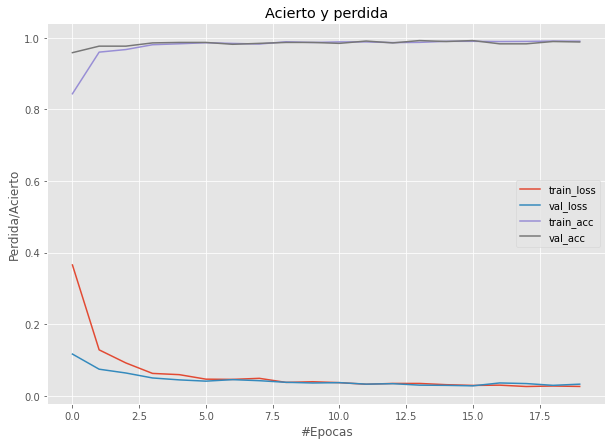

In [19]:
# plot de perdida y acierto entrenamiento y validacion

plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, EPOCAS), historico.history['loss'], label='train_loss')
plt.plot(np.arange(0, EPOCAS), historico.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, EPOCAS), historico.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, EPOCAS), historico.history['val_accuracy'], label='val_acc')

plt.title('Acierto y perdida')
plt.xlabel('#Epocas')
plt.ylabel('Perdida/Acierto')
plt.legend(loc='best')
plt.show();